In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import numpy as np

# Générer des données de régression synthétiques
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
#norm X and y 
X = X / np.max(X, axis=0)
y = y / np.max(y)

# Séparer les données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Convertir les données en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Définir le modèle de régression
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

input_dim = X_train.shape[1]

# Définir la fonction d'objectif pour l'optimisation bayésienne
def objective(params):
    hidden_dim, lr = params
    model = RegressionModel(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_val)
        val_loss = criterion(predictions, y_val)
    
    return val_loss.item()

# Définir l'espace de recherche pour les hyperparamètres
param_space = [
    Integer(10, 100, name='hidden_dim'),
    Real(1e-4, 1e-1, prior='log-uniform', name='lr')
]

# Utiliser skopt pour optimiser les hyperparamètres
res = gp_minimize(objective, param_space, n_calls=20, random_state=42)

In [67]:

print(f"Best parameters: {res.x}")
print(f"Best validation loss: {res.fun}")

# Entraîner et évaluer le modèle avec les meilleurs hyperparamètres
best_hidden_dim, best_lr = res.x
best_model = RegressionModel(input_dim, best_hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(best_model.parameters(), lr=best_lr)

num_epochs = 1000
for epoch in range(num_epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

best_model.eval()
with torch.no_grad():
    predictions = best_model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Final Test Loss: {test_loss.item():.4f}')
    

Best parameters: [99, 0.0884859675380457]
Best validation loss: 0.007810128852725029
Final Test Loss: 0.0013
Final R² score test: 0.9892


In [63]:
#train model with basic hyperparameters
basic_model = RegressionModel(input_dim, 50)
criterion = nn.MSELoss()
optimizer = optim.SGD(basic_model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    basic_model.train()
    optimizer.zero_grad()
    outputs = basic_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    

Final R² score test: 0.9892
Final R² score test: 0.9892


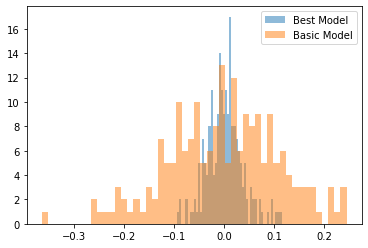

In [70]:
# check the best model used as evaluation
#pass the model in eval mode
import matplotlib.pyplot as plt
best_model.eval()
with torch.no_grad():
    predictions = best_model(X_test)
    test_loss = criterion(predictions, y_test)
    #calculate the final R² score test 
    print(f'Final R² score test: {1 - test_loss.item()/torch.var(y_test).item():.4f}')

basic_model.eval()
with torch.no_grad():
    predictions_basic = basic_model(X_test)
    test_loss = criterion(predictions, y_test)
    #print the final R² score test
    print(f'Final R² score test: {1 - test_loss.item()/torch.var(y_test).item():.4f}')

fig, ax = plt.subplots()
error = y_test.numpy() - predictions.numpy()
error_basic = y_test.numpy() - predictions_basic.numpy()
_ = ax.hist(error, bins=50, alpha=0.5, label='Best Model')
_ = ax.hist(error_basic, bins=50, alpha=0.5, label='Basic Model')
ax.legend()

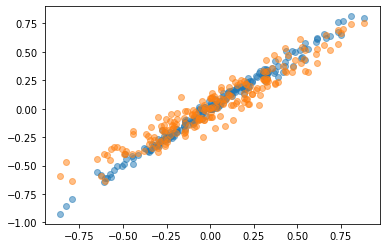

In [71]:
fig, ax = plt.subplots()
_ = ax.scatter(y_test.numpy(), predictions.numpy(), alpha=0.5, label='Best Model')
_ = ax.scatter(y_test.numpy(), predictions_basic.numpy(), alpha=0.5, label='Basic Model')